### Формирование модели машинного обучения

Текущий ноутбук рассматривает анализ датасета [Auto MPG](https://archive.ics.uci.edu/ml/datasets/Auto+MPG).

В работе рассматривается:
1. обучение регрессионной модели для определения потребления автомобилями топлива в городском цикле в галлонах на милю по представленным данным;
2. сохранение обученной модели в виде **конвейера обработки данных** для последующего использования.

In [1]:
import numpy as np
import pandas as pd
from seaborn import pairplot
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from pickle import dump
from pathlib import Path

In [2]:
col_names = ("mpg", "cylinders", "displacement", "horsepower", "weight", 
             "acceleration", "model_year", "origin", "car name")
df = pd.read_csv("../data/auto-mpg-data.tsv", 
                 delim_whitespace=True,
                 names=col_names,
                 header=None)

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


Столбец "`horsepower`" содержит что-то, кроме чисел. Выясним, что.

In [5]:
df["horsepower_floats"] = pd.to_numeric(df["horsepower"], errors='coerce')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mpg                398 non-null    float64
 1   cylinders          398 non-null    int64  
 2   displacement       398 non-null    float64
 3   horsepower         398 non-null    object 
 4   weight             398 non-null    float64
 5   acceleration       398 non-null    float64
 6   model_year         398 non-null    int64  
 7   origin             398 non-null    int64  
 8   car name           398 non-null    object 
 9   horsepower_floats  392 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 31.2+ KB


In [7]:
df[df["horsepower_floats"].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name,horsepower_floats
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto,NaN
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick,NaN
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe,NaN
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra,NaN
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i,NaN
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl,NaN


Итак, столбец "`horsepower`" содержит пропуски, обозначенные знаком вопроса. Заменим их на пустые значения, удалим вспомогательный столбец и колонку "`car name`", которая не используется для анализа.

In [8]:
df["horsepower"] = df["horsepower_floats"]
df = df.drop("horsepower_floats", axis=1)
df = df.drop("car name", axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [10]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


Посмотрим на распределение данных. Какие выводы по ним можно сделать?

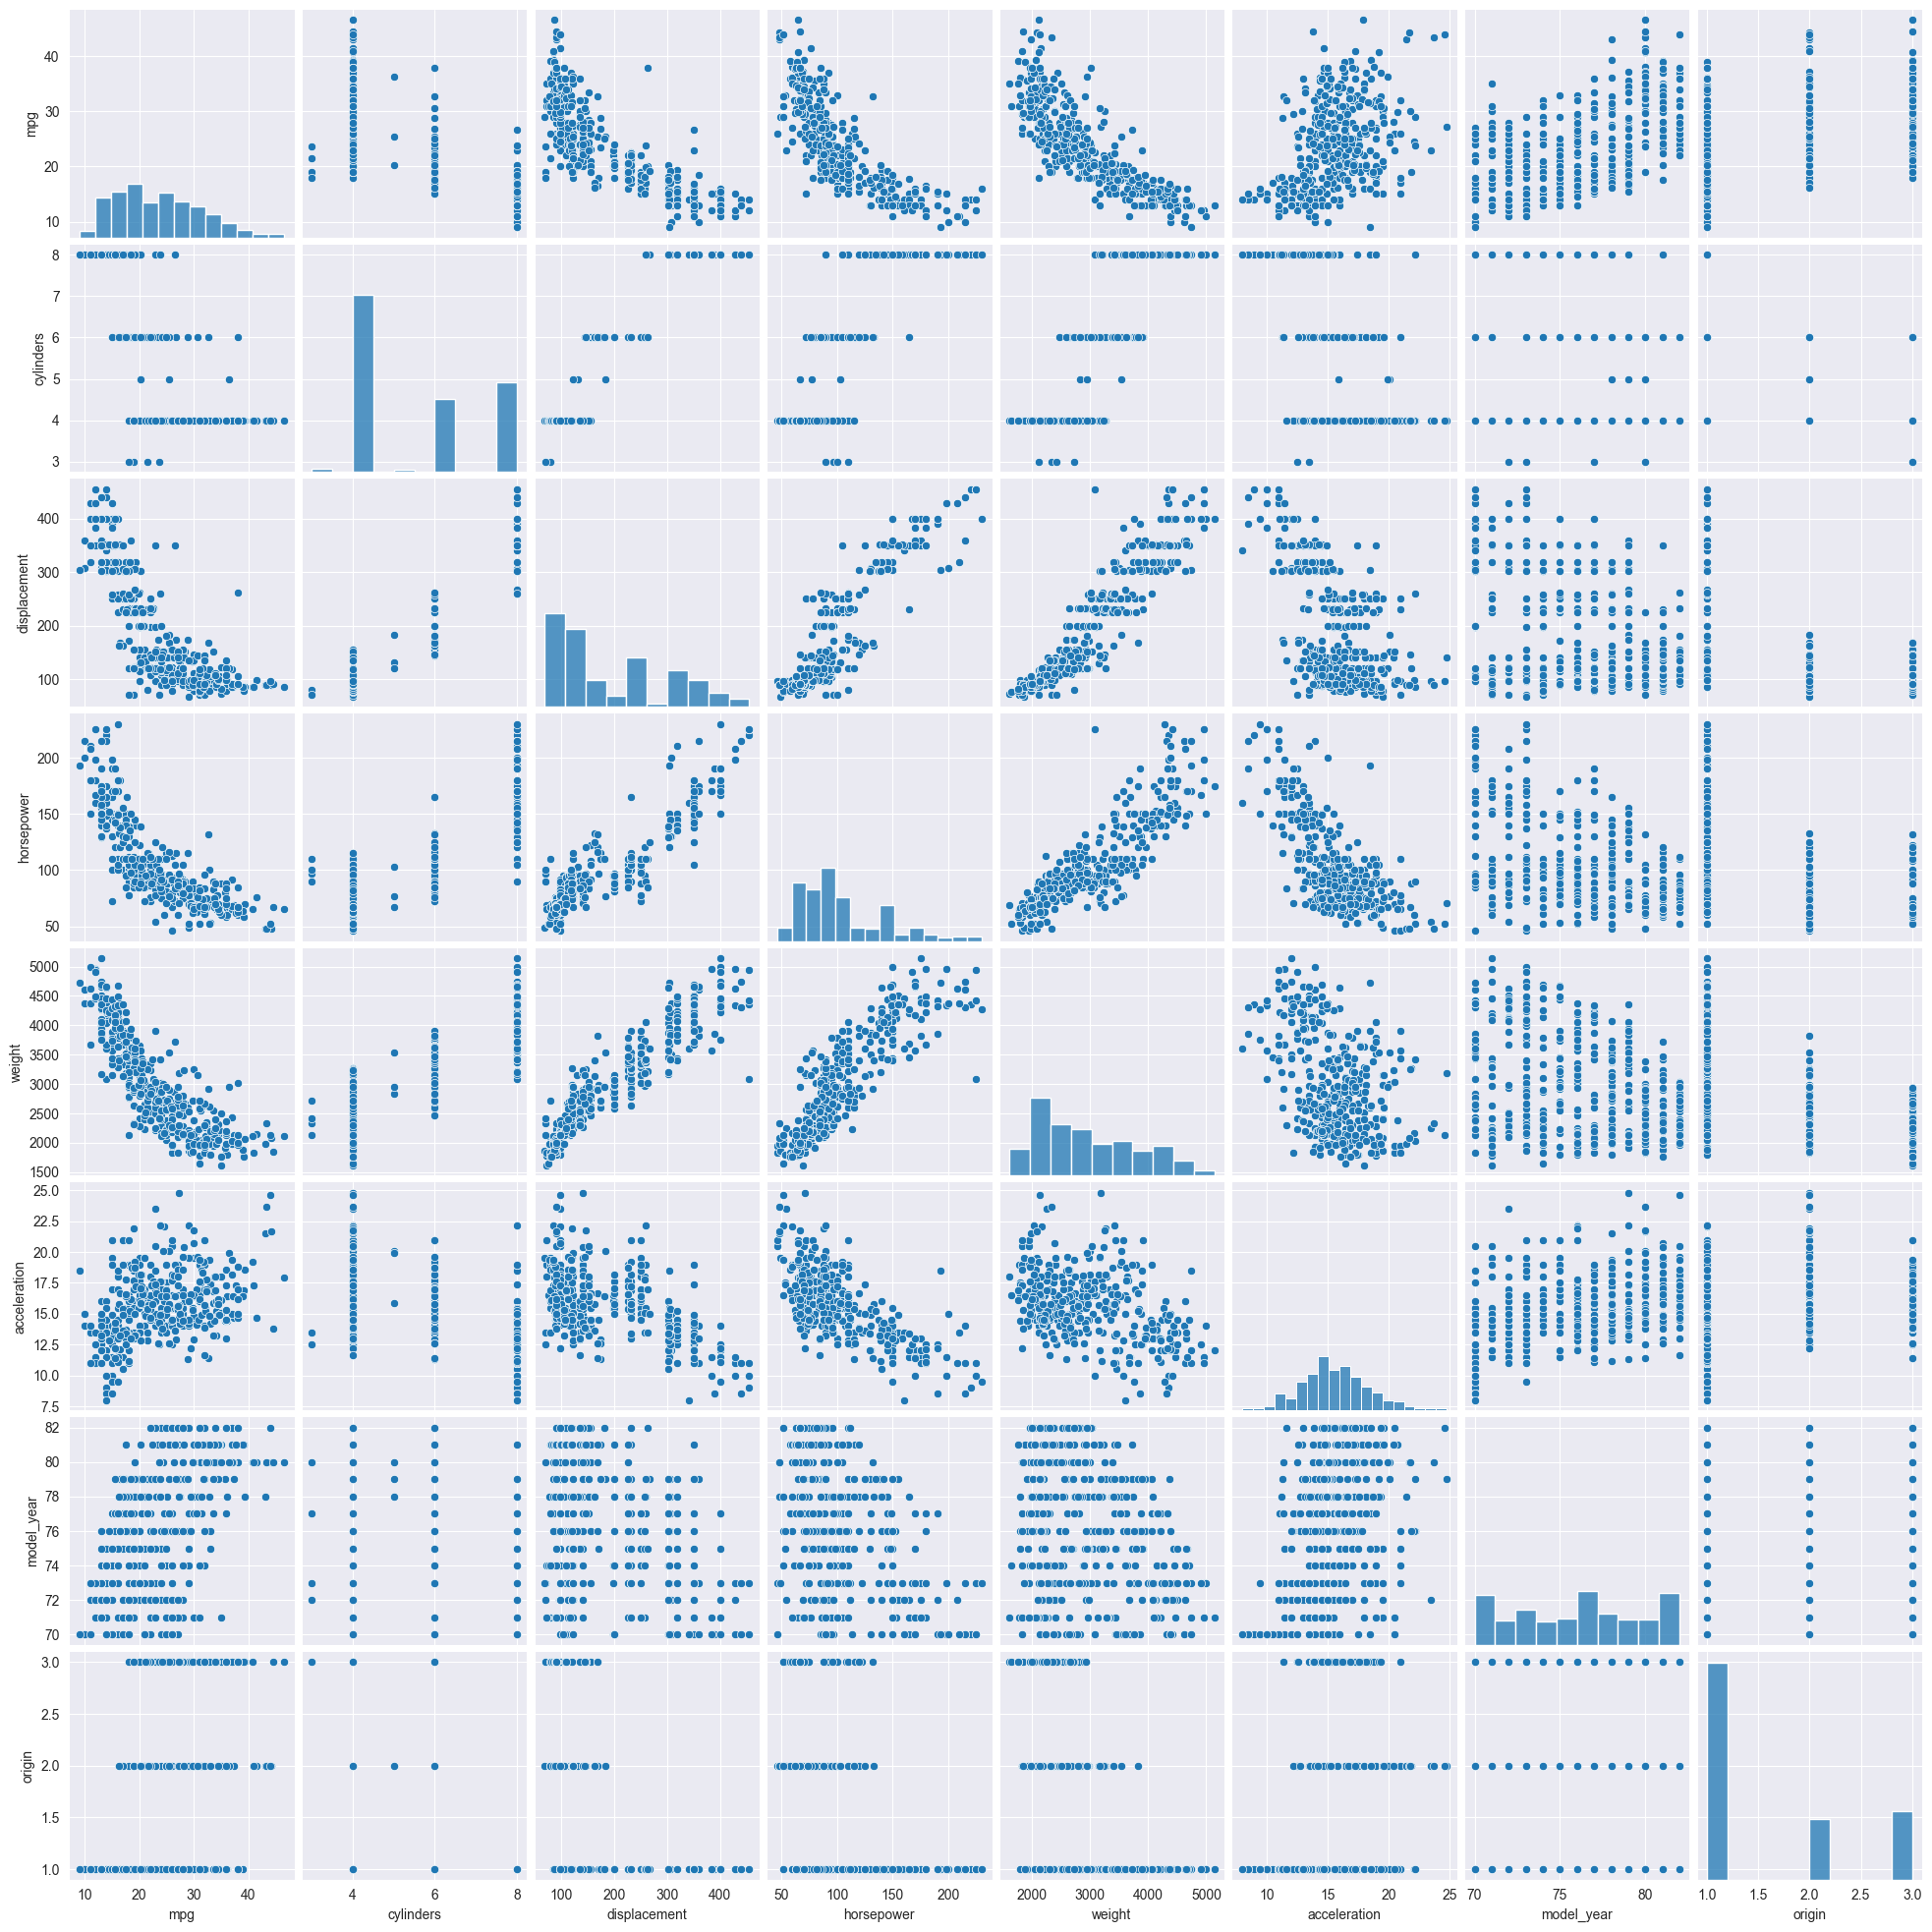

In [11]:
pairplot(df)

Посмторим на распределение категориальных переменных.

In [12]:
df["cylinders"].value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

In [13]:
df["origin"].value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

Выясним, содержатся ли выбросы в данных.

<Axes: >

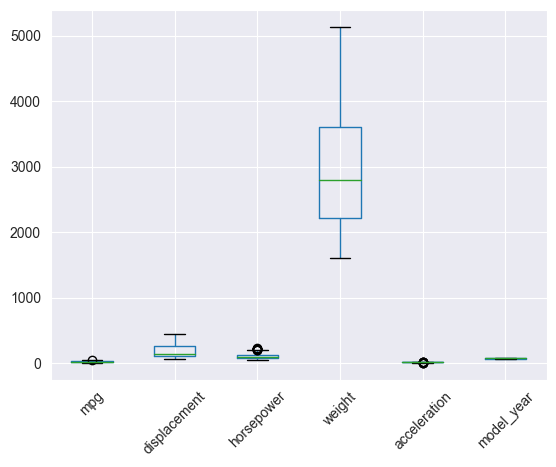

In [14]:
df[["mpg", "displacement", "horsepower", "weight",
    "acceleration", "model_year"]].boxplot(rot=45)

Выбросы есть, но их немного, и они не критичные. Убирать их не будем.

Сформируем конвейеры для обработки количественных и категориальных данных.

In [15]:
numeric_features = ["displacement", "horsepower", "weight", 
                    "acceleration", "model_year"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler()),
    ]
)

In [16]:
categorical_features = ["cylinders", "origin"]
categorical_transformer = Pipeline(
    steps=[
        ("onehot-encoder", OneHotEncoder(drop="first", 
                                         handle_unknown="ignore")),
    ]
)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

In [18]:
regressor = Ridge()
tr_regressor = TransformedTargetRegressor(regressor=regressor,
                                          transformer=MinMaxScaler())
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regressor", tr_regressor)
    ]
)

In [19]:
train, test = train_test_split(df, test_size=0.3)

In [20]:
train.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
56,26.0,4,91.0,70.0,1955.0,20.5,71,1
270,21.1,4,134.0,95.0,2515.0,14.8,78,3
136,16.0,8,302.0,140.0,4141.0,14.0,74,1
295,35.7,4,98.0,80.0,1915.0,14.4,79,1


In [21]:
X_train = train[["cylinders", 
                 "displacement", 
                 "horsepower", 
                 "weight", 
                 "acceleration", 
                 "model_year", 
                 "origin",
                ]]
Y_train = train[["mpg"]]

In [22]:
X_test = test[["cylinders", 
               "displacement", 
               "horsepower", 
               "weight", 
               "acceleration", 
               "model_year", 
               "origin",
              ]]
Y_test = test[["mpg"]]

Подберем коэффициент регуляризации для линейной регрессии.

In [23]:
param_grid = {
    "regressor__regressor__alpha": np.linspace(0.0, 3.0, num=31),
}

In [24]:
search_cv = GridSearchCV(pipe, param_grid)

In [25]:
search_cv.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['displacement',
                                                                          'horsepower',
                                                                          'weight',
                                                                          'acceleration',
                                                                          'model_year']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehot-encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['cylinders',
                                                                          'origin'])])),
                                       ('regressor',
                                        TransformedTargetRegressor(regressor=Ridge(),
                                                                   transformer=MinMaxScaler()))]),
             param_grid={'regressor__regressor__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. ])})

In [26]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'regressor__regressor__alpha': 0.9}


In [27]:
search_cv.score(X_train, Y_train)

0.8516976344771665

In [28]:
search_cv.score(X_test, Y_test)

0.8170162920957983

Сохраним полученный конвейер обработки данных для дальнейшего использования.

In [29]:
Path("../models").mkdir(parents=True, exist_ok=True)

with open("../models/pipeline.pkl", "wb") as file:
    dump(search_cv, file)